In [78]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision.models import vgg16
from collections import namedtuple
import requests
from torch.optim import Adam
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
"""
First we would code U-Net of stable diffusion model. The Followint lines describe important individual components of the U-Net model.
This would try to mimic the stable diffusion model from hugging face, diffusers library.

1)Time Embedding Block: 

Converts time into a fixed size vector.
input (B,) -> output (B, time_emb_dim)
layers [pos_embedding, fc_layer, activation, fc_layer]

Time Embedding -> Time_Stamp_Projection_Layer -> Resnet_Block (between the two convolution blocks)

2) Down Sampling Block:

Increases the number of channels and reduces the spatial dimensions.
input (N, C_in, H, W) -> output (N, C_out, H/2, W/2)

[Resnet Block + Self_Attention_Block] + Down_Sample_Layer.
Resnet Block: [Group_Norm, Activation, Conv2d, time_stamp_info_added, Group_Norm, Activation, Conv2d]
Self_Attention_Block: [Group_Norm, MultiheadAttention]
time_stamp_info_added: [activation, fc_layer]

3) Up Sampling Block:

Decreases the number of channels and increases the spatial dimensions.
Contains a skip connection from the down sampling block.
input (N, C_in, H, W) -> output (N, C_out, H*2, W*2)

Up_Sample_Layer + [Resnet Block + Self_Attention_Block]

4) Middle Block:

Contains the same number of channels and spatial dimensions.
input (N, C, H, W) -> output (N, C, H, W)

Resnet_Block + [Resnet Block + Self_Attention_Block]

"""

'\nFirst we would code U-Net of stable diffusion model. The Followint lines describe important individual components of the U-Net model.\nThis would try to mimic the stable diffusion model from hugging face, diffusers library.\n\n1)Time Embedding Block: \n\nConverts time into a fixed size vector.\ninput (B,) -> output (B, time_emb_dim)\nlayers [pos_embedding, fc_layer, activation, fc_layer]\n\nTime Embedding -> Time_Stamp_Projection_Layer -> Resnet_Block (between the two convolution blocks)\n\n2) Down Sampling Block:\n\nIncreases the number of channels and reduces the spatial dimensions.\ninput (N, C_in, H, W) -> output (N, C_out, H/2, W/2)\n\n[Resnet Block + Self_Attention_Block] + Down_Sample_Layer.\nResnet Block: [Group_Norm, Activation, Conv2d, time_stamp_info_added, Group_Norm, Activation, Conv2d]\nSelf_Attention_Block: [Group_Norm, MultiheadAttention]\ntime_stamp_info_added: [activation, fc_layer]\n\n3) Up Sampling Block:\n\nDecreases the number of channels and increases the spat

In [25]:
URL_MAP = {
    "vgg_lpips": "https://heibox.uni-heidelberg.de/f/607503859c864bc1b30b/?dl=1"
}

CKPT_MAP = {
    "vgg_lpips": "vgg.pth"
}


def download(url, local_path, chunk_size=1024):
    os.makedirs(os.path.split(local_path)[0], exist_ok=True)
    with requests.get(url, stream=True) as r:
        total_size = int(r.headers.get("content-length", 0))
        with tqdm(total=total_size, unit="B", unit_scale=True) as pbar:
            with open(local_path, "wb") as f:
                for data in r.iter_content(chunk_size=chunk_size):
                    if data:
                        f.write(data)
                        pbar.update(chunk_size)


def get_ckpt_path(name, root):
    assert name in URL_MAP
    path = os.path.join(root, CKPT_MAP[name])
    if not os.path.exists(path):
        print(f"Downloading {name} model from {URL_MAP[name]} to {path}")
        download(URL_MAP[name], path)
    return path


class LPIPS(nn.Module):
    def __init__(self):
        super(LPIPS, self).__init__()
        self.scaling_layer = ScalingLayer()
        self.channels = [64, 128, 256, 512, 512]
        self.vgg = VGG16()
        self.lins = nn.ModuleList([
            NetLinLayer(self.channels[0]),
            NetLinLayer(self.channels[1]),
            NetLinLayer(self.channels[2]),
            NetLinLayer(self.channels[3]),
            NetLinLayer(self.channels[4])
        ])

        self.load_from_pretrained()

        for param in self.parameters():
            param.requires_grad = False

    def load_from_pretrained(self, name="vgg_lpips"):
        ckpt = get_ckpt_path(name, "vgg_lpips")
        self.load_state_dict(torch.load(ckpt, map_location=torch.device("cpu")), strict=False)

    def forward(self, real_x, fake_x):
        real_x = 2*real_x - 1
        fake_x = 2*fake_x - 1
        features_real = self.vgg(self.scaling_layer(real_x))
        features_fake = self.vgg(self.scaling_layer(fake_x))
        diffs = {}

        for i in range(len(self.channels)):
            diffs[i] = (norm_tensor(features_real[i]) - norm_tensor(features_fake[i])) ** 2

        return sum([spatial_average(self.lins[i].model(diffs[i])) for i in range(len(self.channels))])


class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer("shift", torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer("scale", torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, x):
        return (x - self.shift) / self.scale


class NetLinLayer(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(NetLinLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )


class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        vgg_pretrained_features = vgg16(pretrained=True).features
        slices = [vgg_pretrained_features[i] for i in range(30)]
        self.slice1 = nn.Sequential(*slices[0:4])
        self.slice2 = nn.Sequential(*slices[4:9])
        self.slice3 = nn.Sequential(*slices[9:16])
        self.slice4 = nn.Sequential(*slices[16:23])
        self.slice5 = nn.Sequential(*slices[23:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        vgg_outputs = namedtuple("VGGOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        return vgg_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)


def norm_tensor(x):
    """
    Normalize images by their length to make them unit vector?
    :param x: batch of images
    :return: normalized batch of images
    """
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + 1e-10)


def spatial_average(x):
    """
     imgs have: batch_size x channels x width x height --> average over width and height channel
    :param x: batch of images
    :return: averaged images along width and height
    """
    return x.mean([2, 3], keepdim=True)

In [52]:
l = LPIPS()
real_x = torch.rand(10, 1, 28, 28)
fake_x = torch.rand(10, 1, 28, 28)
loss = l(real_x, fake_x)
print(loss.shape);

torch.Size([10, 1, 1, 1])


In [29]:
def get_time_embedding(time_steps, temb_dim):
    r"""
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula
    :param time_steps: 1D tensor of length batch size
    :param temb_dim: Dimension of the embedding
    :return: BxD embedding representation of B time steps
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    
    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(
        start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
    )
    
    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb


class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample, num_heads, num_layers, attn, norm_channels):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.attn = attn
        self.t_emb_dim = t_emb_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(self.t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        if self.attn:
            self.attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            
            self.attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
    
    def forward(self, x, t_emb=None):
        out = x
        for i in range(self.num_layers):
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            if self.attn:
                # Attention block of Unet
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        # Downsample
        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads, num_layers, norm_channels):
        super().__init__()
        self.num_layers = num_layers
        self.t_emb_dim = t_emb_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers + 1)
            ]
        )
        
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers + 1)
            ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers + 1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(norm_channels, out_channels)
             for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers + 1)
            ]
        )
    
    def forward(self, x, t_emb=None):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        if self.t_emb_dim is not None:
            out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i + 1](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i + 1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i + 1](out)
            out = out + self.residual_input_conv[i + 1](resnet_input)
        
        return out


class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 up_sample, num_heads, num_layers, attn, norm_channels):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.attn = attn
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
        
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        if self.attn:
            self.attention_norms = nn.ModuleList(
                [
                    nn.GroupNorm(norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )
            
            self.attentions = nn.ModuleList(
                [
                    nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                    for _ in range(num_layers)
                ]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels, in_channels,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down=None, t_emb=None):
        # Upsample
        x = self.up_sample_conv(x)
        
        # Concat with Downblock output
        if out_down is not None:
            x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            # Renset Block
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Self Attention
            if self.attn:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        return out


class UpBlockUnet(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample,
                 num_heads, num_layers, norm_channels):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
            
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(norm_channels, out_channels)
                for _ in range(num_layers)
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down=None, t_emb=None):
        x = self.up_sample_conv(x)
        if out_down is not None:
            x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            # Resnet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            # Self Attention
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
        
        return out

In [30]:
class VQVAE(nn.Module):
    def __init__(self, im_channels, model_config):
        super().__init__()
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        
        # To disable attention in Downblock of Encoder and Upblock of Decoder
        self.attns = model_config['attn_down']
        
        # Latent Dimension
        self.z_channels = model_config['z_channels']
        self.codebook_size = model_config['codebook_size']
        self.norm_channels = model_config['norm_channels']
        self.num_heads = model_config['num_heads']
        
        # Assertion to validate the channel information
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-1]
        assert len(self.down_sample) == len(self.down_channels) - 1
        assert len(self.attns) == len(self.down_channels) - 1
        
        # Wherever we use downsampling in encoder correspondingly use
        # upsampling in decoder
        self.up_sample = list(reversed(self.down_sample))
        
        ##################### Encoder ######################
        self.encoder_conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))
        
        # Downblock + Midblock
        self.encoder_layers = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.encoder_layers.append(DownBlock(self.down_channels[i], self.down_channels[i + 1],
                                                 t_emb_dim=None, down_sample=self.down_sample[i],
                                                 num_heads=self.num_heads,
                                                 num_layers=self.num_down_layers,
                                                 attn=self.attns[i],
                                                 norm_channels=self.norm_channels))
        
        self.encoder_mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.encoder_mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1],
                                              t_emb_dim=None,
                                              num_heads=self.num_heads,
                                              num_layers=self.num_mid_layers,
                                              norm_channels=self.norm_channels))
        
        self.encoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[-1])
        self.encoder_conv_out = nn.Conv2d(self.down_channels[-1], self.z_channels, kernel_size=3, padding=1)
        
        # Pre Quantization Convolution
        self.pre_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)
        
        # Codebook
        self.embedding = nn.Embedding(self.codebook_size, self.z_channels)
        ####################################################
        
        ##################### Decoder ######################
        
        # Post Quantization Convolution
        self.post_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)
        self.decoder_conv_in = nn.Conv2d(self.z_channels, self.mid_channels[-1], kernel_size=3, padding=(1, 1))
        
        # Midblock + Upblock
        self.decoder_mids = nn.ModuleList([])
        for i in reversed(range(1, len(self.mid_channels))):
            self.decoder_mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i - 1],
                                              t_emb_dim=None,
                                              num_heads=self.num_heads,
                                              num_layers=self.num_mid_layers,
                                              norm_channels=self.norm_channels))
        
        self.decoder_layers = nn.ModuleList([])
        for i in reversed(range(1, len(self.down_channels))):
            self.decoder_layers.append(UpBlock(self.down_channels[i], self.down_channels[i - 1],
                                               t_emb_dim=None, up_sample=self.down_sample[i - 1],
                                               num_heads=self.num_heads,
                                               num_layers=self.num_up_layers,
                                               attn=self.attns[i-1],
                                               norm_channels=self.norm_channels))
        
        self.decoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[0])
        self.decoder_conv_out = nn.Conv2d(self.down_channels[0], im_channels, kernel_size=3, padding=1)
    
    def quantize(self, x):
        B, C, H, W = x.shape
        
        # B, C, H, W -> B, H, W, C
        x = x.permute(0, 2, 3, 1)
        
        # B, H, W, C -> B, H*W, C
        x = x.reshape(x.size(0), -1, x.size(-1))
        
        # Find nearest embedding/codebook vector
        # dist between (B, H*W, C) and (B, K, C) -> (B, H*W, K)
        dist = torch.cdist(x, self.embedding.weight[None, :].repeat((x.size(0), 1, 1)))
        # (B, H*W)
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Replace encoder output with nearest codebook
        # quant_out -> B*H*W, C
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        
        # x -> B*H*W, C
        x = x.reshape((-1, x.size(-1)))
        commmitment_loss = torch.mean((quant_out.detach() - x) ** 2)
        codebook_loss = torch.mean((quant_out - x.detach()) ** 2)
        quantize_losses = {
            'codebook_loss': codebook_loss,
            'commitment_loss': commmitment_loss
        }
        # Straight through estimation
        quant_out = x + (quant_out - x).detach()
        
        # quant_out -> B, C, H, W
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        return quant_out, quantize_losses, min_encoding_indices

    def encode(self, x):
        out = self.encoder_conv_in(x)
        for idx, down in enumerate(self.encoder_layers):
            out = down(out)
        for mid in self.encoder_mids:
            out = mid(out)
        out = self.encoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.encoder_conv_out(out)
        out = self.pre_quant_conv(out)
        out, quant_losses, _ = self.quantize(out)
        return out, quant_losses
    
    def decode(self, z):
        out = z
        out = self.post_quant_conv(out)
        out = self.decoder_conv_in(out)
        for mid in self.decoder_mids:
            out = mid(out)
        for idx, up in enumerate(self.decoder_layers):
            out = up(out)
        
        out = self.decoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.decoder_conv_out(out)
        return out
    
    def forward(self, x):
        z, quant_losses = self.encode(x)
        out = self.decode(z)
        return out, z, quant_losses

In [49]:
im_channels = 1
model_config = {
    'down_channels': [ 64, 128],
    'mid_channels': [128, 128],
    'down_sample': [True],
    'num_down_layers': 1,
    'num_mid_layers': 1,
    'num_up_layers': 1,
    'attn_down': [False],
    'z_channels': 64,
    'codebook_size': 64,
    'norm_channels': 32,
    'num_heads': 1
}
model = VQVAE(im_channels, model_config).to(device)
x = torch.rand(10, 1, 28, 28).to(device)
out = model(x)

In [50]:
out[0].shape, out[1].shape, out[2]

(torch.Size([10, 1, 28, 28]),
 torch.Size([10, 64, 14, 14]),
 {'codebook_loss': tensor(0.6195, device='cuda:0', grad_fn=<MeanBackward0>),
  'commitment_loss': tensor(0.6195, device='cuda:0', grad_fn=<MeanBackward0>)})

In [40]:
class Discriminator(nn.Module):
    r"""
    PatchGAN Discriminator.
    Rather than taking IMG_CHANNELSxIMG_HxIMG_W all the way to
    1 scalar value , we instead predict grid of values.
    Where each grid is prediction of how likely
    the discriminator thinks that the image patch corresponding
    to the grid cell is real
    """
    
    def __init__(self, im_channels=3,
                 conv_channels=[64, 128, 256],
                 kernels=[4,4,4,4],
                 strides=[2,2,2,1],
                 paddings=[1,1,1,1]):
        super().__init__()
        self.im_channels = im_channels
        activation = nn.LeakyReLU(0.2)
        layers_dim = [self.im_channels] + conv_channels + [1]
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(layers_dim[i], layers_dim[i + 1],
                          kernel_size=kernels[i],
                          stride=strides[i],
                          padding=paddings[i],
                          bias=False if i !=0 else True),
                nn.BatchNorm2d(layers_dim[i + 1]) if i != len(layers_dim) - 2 and i != 0 else nn.Identity(),
                activation if i != len(layers_dim) - 2 else nn.Identity()
            )
            for i in range(len(layers_dim) - 1)
        ])
    
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [42]:
x = torch.randn((2,3, 256, 256))
prob = Discriminator(im_channels=3)(x)
print(prob.shape)

torch.Size([2, 1, 31, 31])


In [44]:
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist = datasets.MNIST(root="data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(mnist, batch_size=32, shuffle=True)

In [63]:
def train():
    
    model = VQVAE(im_channels, model_config).to(device)
    lpips_model = LPIPS().eval().to(device)
    discriminator = Discriminator(im_channels=im_channels).to(device)

    num_epochs = 10

    recon_criteria = nn.MSELoss()
    disc_criteria = nn.BCEWithLogitsLoss()

    optimizer_d = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_g = Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    disc_step_start = 1500
    step_count = 0

    for epoch_idx in range(num_epochs):
        for im in tqdm(train_loader):
            optimizer_d.zero_grad()
            optimizer_g.zero_grad()

            step_count += 1
            im = im[0].to(device)

            model_output = model(im)
            output, z, quantize_losses = model_output

            recon_loss = recon_criteria(output, im)
            g_loss = (
                recon_loss + quantize_losses['codebook_loss'] + 0.2*quantize_losses['commitment_loss']
            )
            if (step_count > disc_step_start):
                disc_fake_pred = discriminator(output)
                disc_fake_loss = disc_criteria(disc_fake_pred, torch.ones(disc_fake_pred.shape).to(device))
                g_loss += disc_fake_loss
            lpips_loss = torch.mean(lpips_model(output, im))
            g_loss += lpips_loss
            g_loss.backward(retain_graph=True)
            optimizer_g.step()

            if (step_count > disc_step_start):
                fake = output
                disc_fake_pred = discriminator(fake.detach())
                disc_real_pred = discriminator(im)
                disc_fake_loss = disc_criteria(disc_fake_pred, torch.zeros(disc_fake_pred.shape).to(device))
                disc_real_loss = disc_criteria(disc_real_pred, torch.ones(disc_real_pred.shape).to(device))
                disc_loss = (disc_fake_loss + disc_real_loss) / 2
                disc_loss.backward()
                optimizer_d.step()
        
        print(f"Epoch {epoch_idx} => G Loss: {g_loss}, D Loss: {disc_loss if step_count > disc_step_start else None}")
    
    return model, discriminator

In [64]:
model, discriminator = train()

100%|██████████| 1875/1875 [00:56<00:00, 33.07it/s]


Epoch 0 => G Loss: 0.385832279920578, D Loss: 0.815987765789032


100%|██████████| 1875/1875 [01:09<00:00, 27.10it/s]


Epoch 1 => G Loss: 0.40086618065834045, D Loss: 0.8781862258911133


100%|██████████| 1875/1875 [01:09<00:00, 27.02it/s]


Epoch 2 => G Loss: 0.36542582511901855, D Loss: 0.8488467335700989


100%|██████████| 1875/1875 [01:09<00:00, 26.83it/s]


Epoch 3 => G Loss: 0.37934640049934387, D Loss: 0.8167874217033386


100%|██████████| 1875/1875 [01:08<00:00, 27.22it/s]


Epoch 4 => G Loss: 0.35471993684768677, D Loss: 0.8252025842666626


100%|██████████| 1875/1875 [01:09<00:00, 26.93it/s]


Epoch 5 => G Loss: 0.3666578531265259, D Loss: 0.8254597783088684


100%|██████████| 1875/1875 [01:09<00:00, 26.98it/s]


Epoch 6 => G Loss: 0.3979235887527466, D Loss: 0.7948178052902222


100%|██████████| 1875/1875 [01:10<00:00, 26.66it/s]


Epoch 7 => G Loss: 0.3694952726364136, D Loss: 0.8226240277290344


100%|██████████| 1875/1875 [01:10<00:00, 26.71it/s]


Epoch 8 => G Loss: 0.4036768972873688, D Loss: 0.7841628789901733


100%|██████████| 1875/1875 [01:09<00:00, 26.87it/s]

Epoch 9 => G Loss: 0.5001078248023987, D Loss: 0.7300238609313965


In [65]:
# save the model
torch.save(model.state_dict(), "pm_prediction_1.pth")
torch.save(discriminator.state_dict(), "pm_prediction_2.pth")

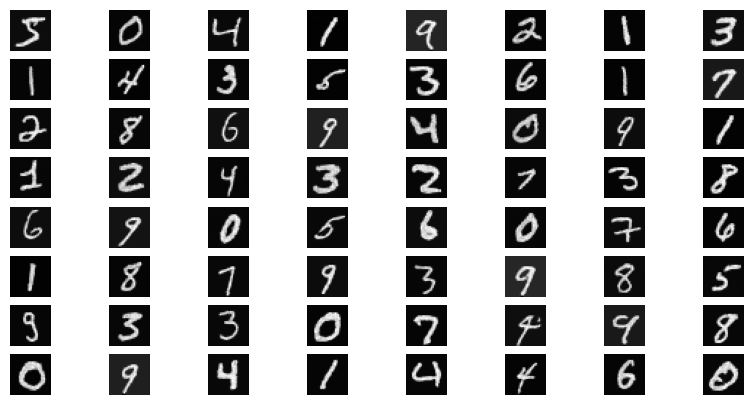

In [79]:
fig, ax = plt.subplots(8, 8, figsize=(10, 5))
for i in range(8):
    for j in range(8):
        x = train_loader.dataset[i*8 + j][0].unsqueeze(0).to(device)
        output, z, quantize_losses = model(x)
        ax[i, j].imshow(output.detach().cpu().numpy().squeeze(), cmap="gray")
        ax[i, j].axis("off")